# Exemplo com dados da Johnson & Johnson #

In [1]:
import numpy as np

import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from matplotlib import pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

import warnings
warnings.filterwarnings('ignore')

In [4]:
data = pd.read_csv('jj.csv')
data.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


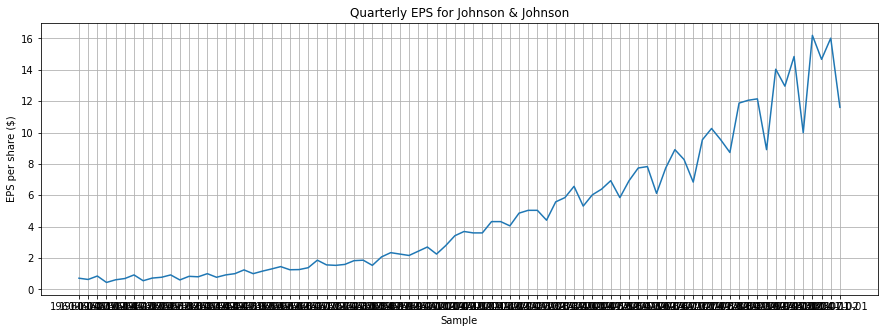

([<matplotlib.lines.Line2D at 0x1a19b8b6d8>], None, None)

In [6]:
plt.figure(figsize=(15,5))
plt.xlabel('Sample')
plt.title('Quarterly EPS for Johnson & Johnson')
plt.ylabel('EPS per share ($)')
plt.plot(data['date'],data['data']), plt.grid(), plt.show()

In [7]:
def get_stationarity(timeseries,window=4*2):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=window).mean()
    rolling_std = timeseries.rolling(window=window).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

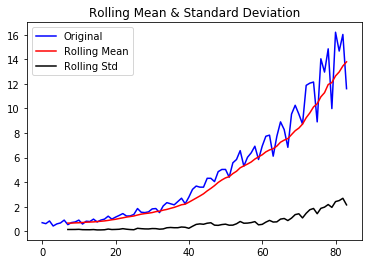

ADF Statistic: 2.7420165734574753
p-value: 1.0
Critical Values:
	1%: -3.524624466842421
	5%: -2.9026070739026064
	10%: -2.5886785262345677


In [8]:
# Augmented Dickey-Fuller test
get_stationarity(data['data'])

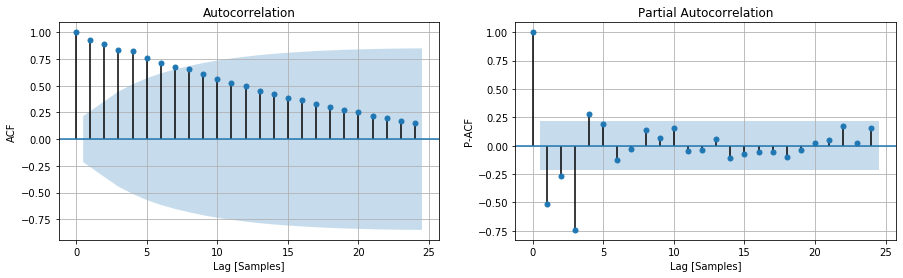

In [11]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=[15, 4])
plot_acf(data['data'],lags=24,ax=ax1)
ax1.set_ylabel('ACF'), ax1.set_xlabel('Lag [Samples]')
ax1.grid(True)
plot_pacf(data['dte'],lags=24,ax=ax2)
ax2.set_ylabel('P-ACF'), ax2.set_xlabel('Lag [Samples]')
ax2.grid(True)
plt.show()

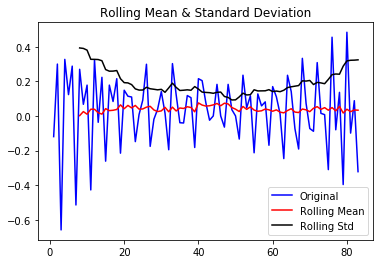

ADF Statistic: -4.317043945811826
p-value: 0.0004149731404440838
Critical Values:
	1%: -3.518281134660583
	5%: -2.899878185191432
	10%: -2.5872229937594873


In [9]:
# Take the log difference to make data stationary

data['dte'] = np.log(data['data']).diff()
data = data.drop(data.index[0])
data.head()

# Augmented Dickey-Fuller test
get_stationarity(data['dte'])

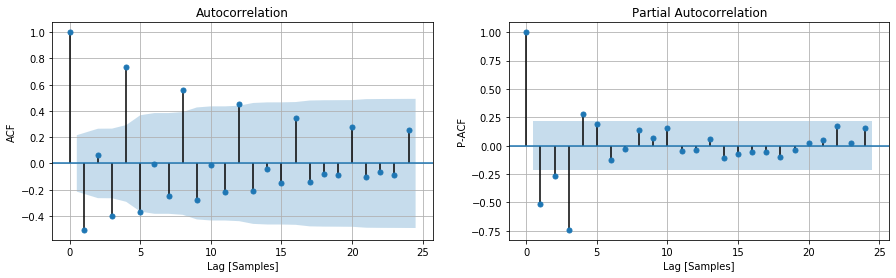

In [10]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=[15, 4])
plot_acf(data['dte'],lags=24,ax=ax1)
ax1.set_ylabel('ACF'), ax1.set_xlabel('Lag [Samples]')
ax1.grid(True)
plot_pacf(data['dte'],lags=24,ax=ax2)
ax2.set_ylabel('P-ACF'), ax2.set_xlabel('Lag [Samples]')
ax2.grid(True)
plt.show()

In [12]:
data['dte'] = np.log(data['data'])
data.head()

,date,data,dte
1,1960-04-01,0.63,-0.462035
2,1960-07-02,0.85,-0.162519
3,1960-10-01,0.44,-0.820981
4,1961-01-01,0.61,-0.494296
5,1961-04-02,0.69,-0.371064


In [21]:
dte = data['dte']
na_s = [0,1,2,3,4,5,6,7,8]
nc_s = [0,1,2,3,4,5,6]
aic_mat = np.zeros((len(na_s),len(nc_s)), dtype=float)

for n_a in na_s:
    for n_c in nc_s:
        modelij = ARIMA(dte, order=(n_a, 1, n_c), trend="t")
        try:
            res = modelij.fit()
            aic_mat[n_a,n_c] = res.aic
        except:
            aic_mat[n_a,n_c] = np.nan

[[-19.61 -69.71 -80.34 -83.87 -101.74 -113.02 -111.50]
 [-42.36 -70.14 -78.60 -85.66 -109.51 -111.49 -111.09]
 [-47.63 -74.03 -71.35 -83.90 -115.85 -109.61 -140.86]
 [-151.94 -153.90 -157.24 -155.29 -153.68 -151.64 -150.34]
 [-155.59 -154.31 -154.73 -153.18 -151.58 -149.55 -144.88]
 [-155.16 -151.95 -155.56 -151.27 -148.96 -148.79 -147.04]
 [-154.39 -152.18 -149.89 -148.64 -148.91 -148.45 -146.48]
 [-153.15 -150.44 -151.23 -146.53 -146.49 -146.52 -144.86]
 [-153.96 -152.39 -150.39 -148.76 -146.48 -149.90 -147.99]]


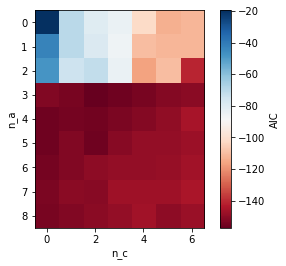

In [22]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})
fig, ax = plt.subplots(1, 1, figsize=[6, 4])
c = ax.imshow(aic_mat, cmap='RdBu')
ax.set_ylabel('n_a'), ax.set_xlabel('n_c')
c_ = fig.colorbar(c, ax=ax)
c_.set_label('AIC')
print(aic_mat)

In [23]:
model = ARIMA(data['dte'], order=(3,1,2),trend="t")
res = model.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                    dte   No. Observations:                   83
Model:                 ARIMA(3, 1, 2)   Log Likelihood                  85.621
Date:                Tue, 04 May 2021   AIC                           -157.241
Time:                        18:30:32   BIC                           -140.394
Sample:                             0   HQIC                          -150.477
                                 - 83                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0396      0.004      9.878      0.000       0.032       0.047
ar.L1         -0.9985      0.058    -17.228      0.000      -1.112      -0.885
ar.L2         -0.9992      0.047    -21.118      0.0

In [24]:
def eval_model(dt,res):
    plt.plot(dt)
    plt.plot(res.fittedvalues[1:], color='red')
    plt.title('Fitted Values')
    plt.xlabel('Sample')
    plt.ylabel('Time series')

    # Resíduos do modelo estimado
    resid = res.resid


    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=[15, 4])
    plot_acf(resid,lags=24,ax=ax1)
    ax1.set_ylabel('ACF'), ax1.set_xlabel('Lag [Samples]')
    ax1.grid(True)
    plot_pacf(resid,lags=24,ax=ax2)
    ax2.set_ylabel('P-ACF'), ax2.set_xlabel('Lag [Samples]')
    ax2.grid(True)
    plt.show()

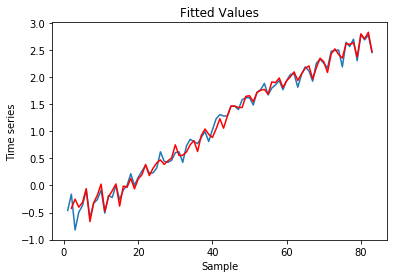

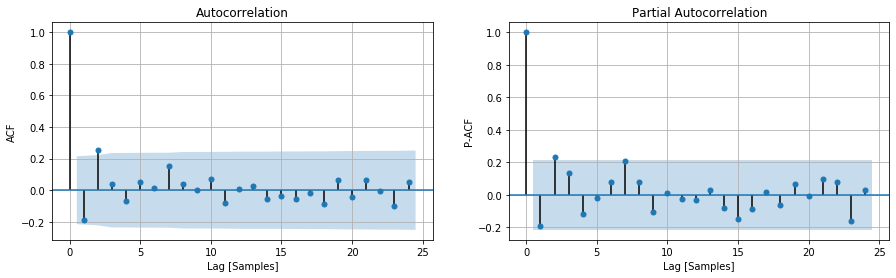

In [25]:
eval_model(data['dte'],res)

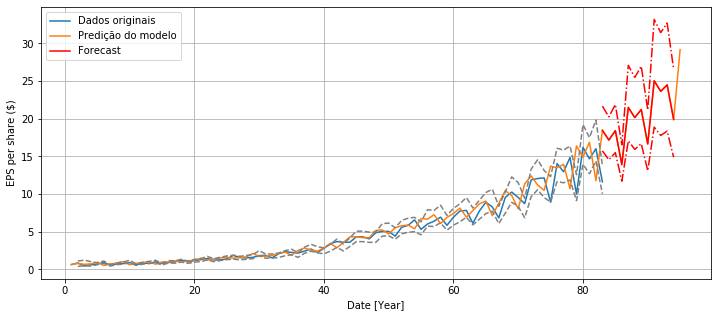

(None, <matplotlib.legend.Legend at 0x1a1b9d5860>, None)

In [26]:
fig, ax = plt.subplots(figsize=(12,5))

# Original data
plt.plot(data['data'],label='Dados originais')

# Model prediction
px = res.predict(start=1, end=len(data['dte'])+12)
plt.plot(np.exp(px), label='Predição do modelo')
# Prediction confidence interval
predict_dy = res.get_prediction()
predict_dy_ci = predict_dy.conf_int()
ax.plot(np.exp(predict_dy_ci[1:]),'--',color='gray')


# Forecast - 3 years
fore = res.get_forecast(steps=12)
forecast_ci = fore.conf_int()
plt.plot(np.exp(forecast_ci),'-.',color='red')
forecasts = np.exp(res.forecast(steps=12))
forecasts.plot(color='red',label='Forecast')

plt.xlabel('Date [Year]')
plt.ylabel('EPS per share ($)')
plt.grid(True), plt.legend(), plt.show()